## Appendix Supplementary material
## Reproducible analysis

#### Introduction 

This tutorial aims to make all the analysis associated with the report "Estimation of soil water content in the entire root-zone". The data analysis was performed using the Jupiterlab 0.35.3.

#### Import the modules

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Define a function to calculate daily profile Soil Water Content

In [12]:

def SWIfn (vwc5,surf_max,sub_surf_max,sub_surf_min,k):
    """"
    Calculates profile soil water content and Soil water index
    
    Inputs
    -vwc5 : Daily measured volumetric water content from a sensor at 5 cm depth (vol/vol)
    -surf_max : Maximun amount of water that surface layer can hold (vol/vol)
    -sub_surf_max : Maximun amount of water that sub-surface layer can hold (vol/vol)
    -sub_surf_min : Minimun amount of water that sub-surface layer can hold (vol/vol)
    -K : the gain of the exponential filter (in this case we are using a fixed value = 1)
    
    Outputs:
    profile_SWC : Daily profile soil water content (milimeters)
    SWI : Daily soil water index (dimensionless)
    
    Author:PR
    Date:16-Apr-2019
    """

    # Create the variables where will store the data 
    SWI = [(vwc5[0]/surf_max)] 
    profile_SWC = [((vwc5[0] * 50) + ((sub_surf_max-sub_surf_min) * 450))] 
    
    
    for i in range(1,len(vwc5)):
        #In case the input data presents NaN values we solve it using the SWI and profile_SWC from the day before
        if np.isnan(vwc5[i]):
            new_SWI = SWI[i-1] * 0.95
            SWI.append(new_SWI)
            sub_surf_storage = SWI[i-1] * (sub_surf_max - sub_surf_min) + sub_surf_min
            profile_SWC_est = (vwc5[i-1] * 50) + (sub_surf_storage * 450)
            profile_SWC.append(profile_SWC_est)  
        
        #If the input data do not have NaN values run the exponential filter
        else:
            #Calculate daily SWI for the second layer from the observations of soil moisture in the first layer (vwc5[i])
            #The SWI is related with the SWI of the previous day and a gain factor K that we are using as a constant K = 1 
            new_SWI = SWI[i-1] + k *((vwc5[i]/surf_max) - SWI[i-1])
            SWI.append(new_SWI)
            
            #Using daily SWI calculated previously we estimate soil water content in the second layer assuming 
            #the changes between two time steps in soil moisture on the sub_surfase are proportional 
            sub_surf_storage = SWI[i] * (sub_surf_max - sub_surf_min) + sub_surf_min
            
            #To calculate the profile SWC we copuling the SWC in the first layer plus SWC in the second layer
            profile_SWC_est = (vwc5[i] * 50) + (sub_surf_storage * 450)
            profile_SWC.append(profile_SWC_est)  

    return profile_SWC, SWI


#### Import data and defining inputs variables

- Data available in the repository to run the function:
    - Cherokee_2018_to_2019.csv
    - Colby_2018_to_2019.csv
    - GardenCity_2018_to_2019.csv
    - Gypsum_2018_to_2019.csv
    - Hays_2018_to_2019.csv
    - Hodgeman_2018_to_2019.csv
    - LakeCity_2018_to_2019.csv
    - Lane_2018_to_2019.csv
<br/>

- In case the user would like to test their own data should import a .cvs file with a name column "VWC5CM" for the observed data at surface and go directly to execute the function.

- Figure 1 and 2 are imported directly from the repository

In [18]:
#Import an example, set directory and file name

dirname = '/Users/prossini/Desktop/coding/Project_SWI/'
filname = 'LakeCity_2018_to_2019.csv'
mesonet_data = pd.read_csv(dirname + filname)

#From mesonet_data calculate variables to evaluate the exponential filter outputs
SWC5 = (mesonet_data.VWC5CM * 50).rolling(2, min_periods=1,center=True).mean()                 
SWC10 = (mesonet_data.VWC5CM  + mesonet_data.VWC10CM)/2 * 50
SWC20 = (mesonet_data.VWC10CM + mesonet_data.VWC20CM)/2 * 100
SWC50 = (mesonet_data.VWC20CM + mesonet_data.VWC50CM)/2 * 300 

profile_SWC_sensors = SWC5 + SWC10 + SWC20 + SWC50
sub_surface_SWC_sensors = SWC10 + SWC20 + SWC50;

#Create a range of dates for plotting results
dates = pd.date_range(mesonet_data.TIMESTAMP[0], periods=mesonet_data.shape[0], freq='d')
total_precip = round(mesonet_data.PRECIP.sum(),1)

#Defining inputs to run the function
vwc5 = mesonet_data.VWC5CM.rolling(2, min_periods=1,center=True).mean()     
surface_max = np.max(vwc5)                       
sub_surf_max = np.max(sub_surface_SWC_sensors)/450                  
sub_surf_min = np.min(sub_surface_SWC_sensors)/450

#### Execute the SWIfn function and calculate the agreement between measured and calculated values

In [19]:

profile_SWC,SWI = SWIfn(vwc5,surface_max,sub_surf_max,sub_surf_min,1)

#Calculate Root mean square error
RMSE = round(np.sqrt(np.mean((profile_SWC-profile_SWC_sensors)**2)),2)
#Calculate Mean absolute error
MAE = round(np.mean(np.abs(profile_SWC-profile_SWC_sensors)),2)

#Profile SWC ave, max and min to creaate table 1 for each station
print(np.mean(profile_SWC))
print(np.min(profile_SWC))
print(np.max(profile_SWC))

54.87971159323395
26.91438734455008
119.0025


#### Ploting predicted vs observed profile soil moisture
##### Code to generate Figure 3. To generate a plot for other stations should import the data for the desired station and run the code individually

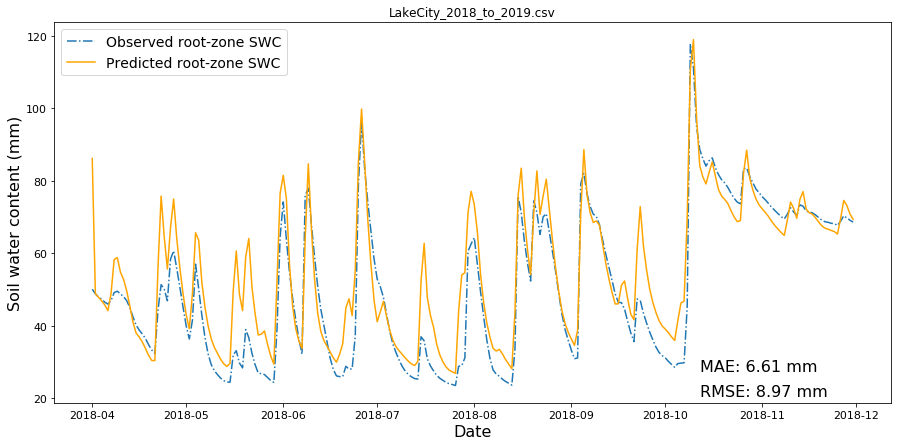

In [20]:
#Create a figure
plt.figure(figsize=(15,7))

#observed data
plt.plot(dates,profile_SWC_sensors,'-.') 
#predicted data
plt.plot(dates,profile_SWC,'orange') 

#Define leged, axis labels,title
plt.legend(['Observed root-zone SWC','Predicted root-zone SWC'],fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Soil water content (mm)',fontsize=16)
plt.rcParams['ytick.labelsize'] = 11.0
plt.rcParams['xtick.labelsize'] = 11.0
plt.title(filname,  fontdict=None, loc='center', pad=None)

# Add information about model agreement
annotation_label = 'RMSE: ' + str(RMSE) + ' mm'
plt.annotate(annotation_label, xy=(700, 50), xycoords='figure points', fontsize=16)
annotation_label = 'MAE: ' + str(MAE) + ' mm'
plt.annotate(annotation_label, xy=(700, 75), xycoords='figure points', fontsize=16)
plt.show()



#### Ploting predicted root_zone SWC and precipitation
##### Supplementary figure 1

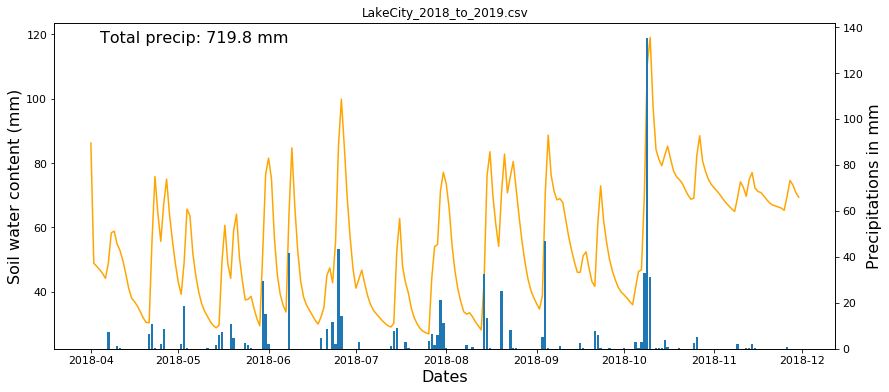

In [21]:
plt.figure(figsize=(14,6))

ax1 = plt.subplot()
ax1.plot(dates,profile_SWC,'orange')
ax2 = ax1.twinx()
ax2.bar(dates,mesonet_data.PRECIP)

ax1.set_xlabel('Dates',fontsize=16)
ax1.set_ylabel('Soil water content (mm)', fontsize=16)
ax2.set_ylabel('Precipitations in mm', fontsize=16)
plt.title(filname,  fontdict=None, loc='center', pad=None)

# Add information
annotation_label = 'Total precip: ' + str(total_precip) + ' mm'
plt.annotate(annotation_label, xy=(100,350), xycoords='figure points', fontsize=16)
plt.show()